# TD学習について

---

今回は強化学習の１種のアルゴリズムであるTD(λ)学習について説明していきます．

$\hat{V}\left(s_t\right)$をtステップ目の推定価値関数とします．

### TD(0)法

TD誤差を次のように設定し，$\delta:=r_t+\gamma \hat{V}\left(s_{t+1}\right)-\hat{V}\left(s_t\right)$を使い,$\hat{V}\left(s_t\right)$が次のように更新していきます．

$$
\hat{V}\left(s_t\right):=\hat{V}\left(s_t\right)+\alpha_t \delta
$$

これをTD(0)法またはTD法と言います．

ここからはTD法を一般化したTD(λ)法を解説します．

---

### TD(λ)法

上の例では1ステップ先での予測誤差を使っていますね．

ここでnステップ先の予測価値を使ってみましょう．

$$
c_t^{(n)} \triangleq r_t+\gamma r_{t+1}+\cdots+\gamma^n \hat{V}\left(s_{t+n}\right)
$$

上はtからnステップ先の予測価値ですね．

この時のTD誤差は次のようになります．
$$
\delta_t^{(n)} \triangleq c_t^{(n)}-\hat{V}\left(s_t\right)=c_t^{(n)}-c_t^{(0)}
$$


ここでさらに一般化して複数ステップでの予測価値を使っていきます．

どれほど，長期のステップを重要視するかを調整する新しい割引変数λを導入します．

$$
c_{t, \lambda} \triangleq \begin{cases}(1-\lambda) \sum_{n=1}^{\infty} \lambda^{n-1} c_t^{(n)} & (\lambda \in[0,1)) \\ c_t^{(\infty)} & (\lambda=1)\end{cases}
$$

このように書くと，TD誤差は次のように書けます．

$$
\delta_{t, \lambda} \triangleq c_{t, \lambda}-\hat{V}\left(s_t\right)
$$

これは**前方観測的なTD(λ)誤差**と言います．

λが1に近ければ近いほど，モンテカルロ推定に近くなり，実際の観測する報酬と近いので推定の偏りは小さくなる一方で，推定の分散が大きくなることが知られています．

上のTD誤差を使い，新しく予測価値関数の更新則を書き直すと，
$$
\hat{V}\left(s_t\right):=\hat{V}\left(s_t\right)+\alpha_t \delta_{t, \lambda}
$$

しかしながら，式を見て分かるように，TD誤差を求めるのに，未来の価値まで観測してから更新しなければならないので，計算に大きなコストが発生しますね，

このことからオンライン学習には適していません．

---

この考えをもう少し，オンライン学習に適した形にしてみましょう.

$$
\begin{aligned}
\delta_t \lambda & (1-\lambda)\left(\sum_{n=1}^{\infty} \lambda^{n-1} r_t+\gamma \sum_{n=2}^{\infty} \lambda^{n-1} r_{t+1}+\gamma^2 \sum_{n=3}^{\infty} \lambda^{n-1} r_{t+2}+\cdots\right) \\
& +(1-\lambda)\left(\gamma \hat{V}\left(s_{t+1}\right)+\lambda \gamma^2 \hat{V}\left(s_{t+2}\right)+\lambda^2 \gamma^3 \hat{V}\left(s_{t+3}\right)+\cdots\right)-\hat{V}\left(s_t\right) \\
= & r_t+\lambda \gamma r_{t+1}+\lambda^2 \gamma^2 r_{t+2}+\cdots \\
& +(1-\lambda)\left(\gamma \hat{V}\left(s_{t+1}\right)+\lambda \gamma^2 \hat{V}\left(s_{t+2}\right)+\lambda^2 \gamma^3 \hat{V}\left(s_{t+3}\right)+\cdots\right)-\hat{V}\left(s_t\right) \\
= & \left(r_t+\gamma \hat{V}\left(s_{t+1}\right)-\hat{V}\left(s_t\right)\right) \\
& +\lambda \gamma\left(r_{t+1}+\gamma \hat{V}\left(s_{t+2}\right)-\hat{V}\left(s_{t+1}\right)\right) \\
& +\lambda^2 \gamma^2\left(r_{t+2}+\gamma \hat{V}\left(s_{t+3}\right)-\hat{V}\left(s_{t+2}\right)\right)+\cdots
\end{aligned}
$$

上の式をシグマ和を使って書き直すと，
$$
\delta_{t, \lambda}=\sum_{n=0}^{\infty}(\lambda \gamma)^n \delta_{t+n}
$$

これを任意の時間Tステップ時までと，それ以降のTD誤差に分解すると，

$$
\delta_{t, \lambda}=\sum_{\tau=t}^T(\lambda \gamma)^{\tau-t} \delta_\tau+\sum_{\tau=T+1}^{\infty}(\lambda \gamma)^{\tau-t} \delta_\tau
$$

右辺の第2項は計算できないですが，第1項目は計算できますね．

ここで各状態のトータルの更新量を考えます．

ある特定の状態sについて，Tステップまでにsを訪問した時間ステップの集合を$\mathcal{T}_s \triangleq\left\{t_1, t_2, \ldots, t_n\right\}$とすると，ステップTまでのTD(λ)の誤差の和は次のようになります．

$$
\Delta_T(s) \triangleq \delta_{t_1, \lambda}+\delta_{t_2, \lambda}+\cdots+\delta_{t_n, \lambda}
$$

このようにすると計算可能な誤差項は次のようになります．

$$
\Delta_T^{\text {past }}(s) \triangleq \sum_{\tau=t_1}^T(\lambda \gamma)^{\tau-t_1} \delta_\tau+\sum_{\tau=t_2}^T(\lambda \gamma)^{\tau-t_2} \delta_\tau+\cdots+\sum_{\tau=t_n}^T(\lambda \gamma)^{\tau-t_n} \delta_\tau
$$

---

ここからコードの説明をしていきます．

まず，TD(λ)法のコードを実装する前に，MDPを用意して，そのMDPに対する最適な価値関数を求めます．

求めた後に，TD(λ)法で計算した推定価値関数と比較すればいいですね．



In [157]:
# MDPの構築

import numpy as np
import jax
import jax.numpy as jnp
from typing import NamedTuple,Optional
np.random.seed(0)

S = 5 # 状態数
A = 3 # 行動数
S_set = jnp.arange(S)
A_set = jnp.arange(A)
gamma = 0.9 # 割引率

rew = np.random.randn(S,A) # 報酬
rew = jnp.array(rew)

P = np.random.rand(S,A,S) # 遷移確率
P = P.reshape(S*A,S)
P = P/np.sum(P,axis=1,keepdims=True) # 正規化
P = P.reshape(S,A,S)
P = jnp.array(P)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)

class MDP(NamedTuple):
    S_set: jnp.ndarray
    A_set: jnp.ndarray
    rew: jnp.ndarray
    P: jnp.ndarray
    gamma: float
    H: int
    optimal_V: Optional[jnp.ndarray] = None

    @property
    def S(self):
        return len(self.S_set)

    @property
    def A(self):
        return len(self.A_set)

H = int (1/(1-gamma) + 1000)
mdp = MDP(S_set,A_set,rew,P,gamma,H)

In [158]:
# 最適な価値関数の計算
from functools import partial

@partial(jax.jit,static_argnames=('S','A'))
def _optimal_Q(S:int,A:int,mdp:MDP):
    Q = jnp.zeros((S,A))

    def backup(Q):
        V = jnp.max(Q,axis=1)
        return mdp.rew + mdp.gamma * jnp.dot(mdp.P,V)
    
    body_fn = lambda i,Q: backup(Q)
    return jax.lax.fori_loop(0,mdp.H,body_fn,Q)

compute_optimal_Q = lambda mdp : _optimal_Q(mdp.S,mdp.A,mdp)
optimal_Q = compute_optimal_Q(mdp)
optimal_V = jnp.max(optimal_Q,axis=1)
mdp = mdp._replace(optimal_V=optimal_V)

In [159]:

def TD_lambda(lam:float,mdp:MDP,T:int,history:np.ndarray,V:jnp.ndarray,alpha:float):
    S,A = mdp.S,mdp.A
    for s in range(S):
        sigma = 0
        s_index = np.where(history[:,0] == s)[0]
        for s_i in s_index:
            for i in range(s_i,T):
                sigma += (lam * mdp.gamma) ** i *(history[:,1][s_i+i] + mdp.gamma * V[int(history[:,0][s_i+i+1])] - V[int(history[:,0][s_i+i])])

        V[s] = V[s] + alpha * sigma

    return V


In [160]:
T = 20
lam = 0.5
alpha = 0.3
history = np.zeros((H,2))
V = np.zeros(mdp.S)
s = np.random.choice(mdp.S)
for i in range(H):
    action = np.random.choice(mdp.A)
    reward = mdp.rew[s,action] 
    # s_next = np.random.choice(mdp.S_set,p=mdp.P[s,action])
    s_next = np.random.choice(mdp.S_set,p=[0.2,0.2,0.2,0.2,0.2])
    history[i] = [s,reward]
    s = s_next
    if i+1 > T:
        V = TD_lambda(lam,mdp,T,history,V,alpha)

V =V.reshape(5,1)
optimal_V = optimal_V.reshape(5,1)


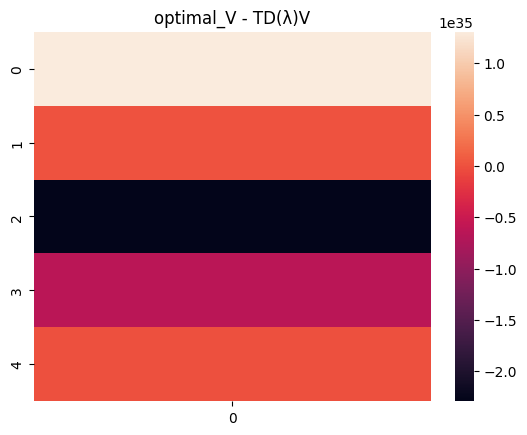

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(optimal_V-V)
plt.title('optimal_V - TD(λ)V')
plt.show()


収束してそうですね．

今回はλと学習率などを固定したので，for文で色々なものを試しても面白そう．